In [1]:
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Retrieve the data
Belem = pd.read_csv(Path() / "data" / "obs-pr" / "belem.csv")
Helsinki = pd.read_csv(Path() / "data" / "obs-pr" / "helsinki.csv")
ERA5 = xr.open_dataset(Path() / "data" / "era5-pr" / "data.nc")

In [3]:
# Extract the data variables
Time = ERA5["valid_time"].data
ERA5_PR = ERA5["tp"] * 1000
Belem_PR = Belem["PR"]
Helsinki_PR = Helsinki["PR"]

In [4]:
ERA5_Belem_PR = ERA5_PR.sel(
    latitude=-1.4563, longitude=360 - 48.5013, method="nearest"
).data
ERA5_Helsinki_PR = ERA5_PR.sel(
    latitude=60.1699, longitude=24.9384, method="nearest"
).data

In [5]:
ERA5_PR.shape, Belem_PR.shape, Helsinki_PR.shape

((72, 721, 1440), (72,), (72,))

In [6]:
def plot_positive_precipitation(pr, ax, y, c):
    foox = []
    fooy = []
    lastx = None
    wasgap = pr[0] <= 0.0

    for t, p in zip(Time, pr):
        if p > 0.0:
            if wasgap:
                wasgap = False
                foox.append(t - (t - lastx) / 2)
            else:
                foox.append(t)
            fooy.append(y)
        else:
            if not wasgap:
                wasgap = True
                foox.append(t - (t - lastx) / 2)
                fooy.append(y)
                ax.plot(foox, fooy, lw=2, c=c, solid_capstyle="butt")
                foox = []
                fooy = []
        lastx = t

    if len(foox) > 0:
        ax.plot(foox, fooy, lw=2, c=c, solid_capstyle="butt")

In [7]:
def plot_negative_precipitation(pr, ax, y):
    foox = []
    fooy = []
    lastx = None
    wasgap = pr[0] >= 0.0

    for t, p in zip(Time, pr):
        if p < 0.0:
            if wasgap:
                wasgap = False
                foox.append(t - (t - lastx) / 2)
            else:
                foox.append(t)
            fooy.append(y)
        else:
            if not wasgap:
                wasgap = True
                foox.append(t - (t - lastx) / 2)
                fooy.append(y)
                ax.plot(foox, fooy, lw=4, c="red", solid_capstyle="butt")
                foox = []
                fooy = []
        lastx = t

    if len(foox) > 0:
        ax.plot(foox, fooy, lw=4, c="red", solid_capstyle="butt")

In [8]:
def extract_and_plot(
    my_ERA5_PR: xr.DataArray,
    my_Belem_PR: pd.DataFrame,
    my_Helsinki_PR: pd.DataFrame,
    title: str,
):
    my_ERA5_Belem_PR = my_ERA5_PR.sel(
        latitude=-1.4563, longitude=360 - 48.5013, method="nearest"
    ).data
    my_ERA5_Helsinki_PR = my_ERA5_PR.sel(
        latitude=60.1699, longitude=24.9384, method="nearest"
    ).data

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.25))

    ax1.set_title(f"{title}: ERA5")
    ax2.set_title("Observations")

    pos = mdates.HourLocator(byhour=(0, 6, 12, 18))
    fmt = mdates.DateFormatter("%d-%m %Hh")

    bf = ax1.fill_between(
        Time,
        my_ERA5_Belem_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_ERA5_Belem_PR) - np.sum(ERA5_Belem_PR)) / np.sum(ERA5_Belem_PR), precision=1, min_digits=1, sign=True)}%",
    )
    hf = ax1.fill_between(
        Time,
        my_ERA5_Helsinki_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_ERA5_Helsinki_PR) - np.sum(ERA5_Helsinki_PR)) / np.sum(ERA5_Helsinki_PR), precision=1, min_digits=1, sign=True)}%",
    )

    bp = ax1.plot(Time, my_ERA5_Belem_PR)
    hp = ax1.plot(Time, my_ERA5_Helsinki_PR)

    plot_positive_precipitation(my_ERA5_Belem_PR, ax1, -2, bp[0].get_c())
    plot_negative_precipitation(my_ERA5_Belem_PR, ax1, -2)
    plot_positive_precipitation(my_ERA5_Helsinki_PR, ax1, -1, hp[0].get_c())
    plot_negative_precipitation(my_ERA5_Helsinki_PR, ax1, -1)

    bpp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-2],
        lw=2,
        c=bp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_ERA5_Belem_PR > 0) - np.sum(ERA5_Belem_PR > 0)) / np.sum(ERA5_Belem_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    bfp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-2],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_ERA5_Belem_PR > 0) != (ERA5_Belem_PR > 0)), precision=1, min_digits=1)}%",
    )
    bnp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-2],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_ERA5_Belem_PR < 0), precision=1, min_digits=1)}%",
    )
    hpp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-1],
        lw=2,
        c=hp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_ERA5_Helsinki_PR > 0) - np.sum(ERA5_Helsinki_PR > 0)) / np.sum(ERA5_Helsinki_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    hfp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-1],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_ERA5_Helsinki_PR > 0) != (ERA5_Helsinki_PR > 0)), precision=1, min_digits=1)}%",
    )
    hnp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-1],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_ERA5_Helsinki_PR < 0), precision=1, min_digits=1)}%",
    )

    bm = ax1.scatter(
        [Time[np.argmax(my_ERA5_Belem_PR)]],
        [np.amax(my_ERA5_Belem_PR)],
        marker="o",
        facecolors="none",
        edgecolors=bp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_ERA5_Belem_PR)] - Time[np.argmax(ERA5_Belem_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_ERA5_Belem_PR) - np.amax(ERA5_Belem_PR), precision=2, min_digits=2, sign=True)}mm",
    )
    hm = ax1.scatter(
        [Time[np.argmax(my_ERA5_Helsinki_PR)]],
        [np.amax(my_ERA5_Helsinki_PR)],
        marker="o",
        facecolors="none",
        edgecolors=hp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_ERA5_Helsinki_PR)] - Time[np.argmax(ERA5_Helsinki_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_ERA5_Helsinki_PR) - np.amax(ERA5_Helsinki_PR), precision=2, min_digits=2, sign=True)}mm",
    )

    ax1.set_ylabel("ERA5 PR (mm)")
    ax1.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax1.set_xlim(Time.min(), Time.max())
    ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=30, ha="right")
    ax1.set_ylim(-3, 24)

    l1 = ax1.legend(
        handles=[hm, hf, *hpp, *hfp, *hnp], loc="upper left", title="Helsinki, Finland"
    )
    ax1.legend(
        handles=[bm, bf, *bpp, *bfp, *bnp], loc="upper right", title="Belem, Brazil"
    )
    ax1.add_artist(l1)

    bf = ax2.fill_between(
        Time,
        my_Belem_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_Belem_PR) - np.sum(Belem_PR)) / np.sum(Belem_PR), precision=1, min_digits=1, sign=True)}%",
    )
    hf = ax2.fill_between(
        Time,
        my_Helsinki_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_Helsinki_PR) - np.sum(Helsinki_PR)) / np.sum(Helsinki_PR), precision=1, min_digits=1, sign=True)}%",
    )

    bp = ax2.plot(Time, my_Belem_PR)
    hp = ax2.plot(Time, my_Helsinki_PR)

    plot_positive_precipitation(my_Belem_PR, ax2, -2, bp[0].get_c())
    plot_negative_precipitation(my_Belem_PR, ax2, -2)
    plot_positive_precipitation(my_Helsinki_PR, ax2, -1, hp[0].get_c())
    plot_negative_precipitation(my_Helsinki_PR, ax2, -1)

    bpp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-2],
        lw=2,
        c=bp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_Belem_PR > 0) - np.sum(Belem_PR > 0)) / np.sum(Belem_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    bfp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-2],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_Belem_PR > 0) != (Belem_PR > 0)), precision=1, min_digits=1)}%",
    )
    bnp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-2],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_Belem_PR < 0), precision=1, min_digits=1)}%",
    )
    hpp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-1],
        lw=2,
        c=hp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_Helsinki_PR > 0) - np.sum(Helsinki_PR > 0)) / np.sum(Helsinki_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    hfp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-1],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_Helsinki_PR > 0) != (Helsinki_PR > 0)), precision=1, min_digits=1)}%",
    )
    hnp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-1],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_Helsinki_PR < 0), precision=1, min_digits=1)}%",
    )

    bm = ax2.scatter(
        [Time[np.argmax(my_Belem_PR)]],
        [np.amax(my_Belem_PR)],
        marker="o",
        facecolors="none",
        edgecolors=bp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_Belem_PR)] - Time[np.argmax(Belem_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_Belem_PR) - np.amax(Belem_PR), precision=2, min_digits=2, sign=True)}mm",
    )
    hm = ax2.scatter(
        [Time[np.argmax(my_Helsinki_PR)]],
        [np.amax(my_Helsinki_PR)],
        marker="o",
        facecolors="none",
        edgecolors=hp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_Helsinki_PR)] - Time[np.argmax(Helsinki_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_Helsinki_PR) - np.amax(Helsinki_PR), precision=2, min_digits=2, sign=True)}mm",
    )

    ax2.set_ylabel("OBS PR (mm)")
    ax2.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax2.set_xlim(Time.min(), Time.max())
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=30, ha="right")
    ax2.set_ylim(-3, 24)

    l1 = ax2.legend(
        handles=[hm, hf, *hpp, *hfp, *hnp], loc="upper left", title="Helsinki, Finland"
    )
    ax2.legend(
        handles=[bm, bf, *bpp, *bfp, *bnp], loc="upper right", title="Belem, Brazil"
    )
    ax2.add_artist(l1)

    plt.tight_layout()

    plt.show()

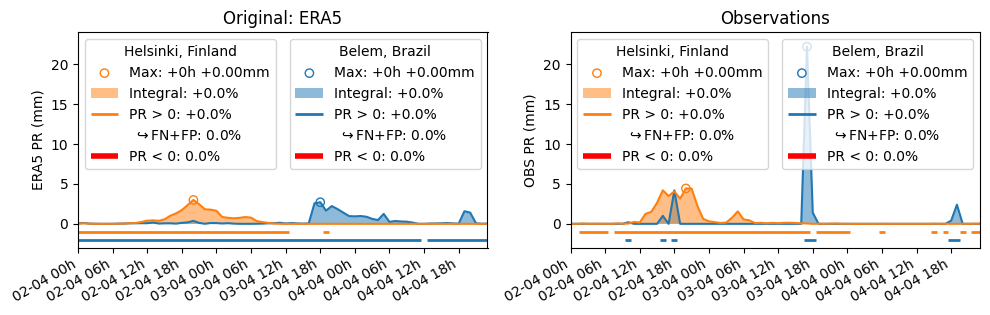

In [9]:
extract_and_plot(ERA5_PR, Belem_PR, Helsinki_PR, "Original")

In [10]:
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp import Zfp

In [11]:
def encode_decode(codec):
    ERA5_PR_codec = ERA5_PR.copy(data=codec.decode(codec.encode(ERA5_PR.values)))

    Belem_PR_codec = Belem_PR.copy(deep=True)
    Belem_PR_codec.values[:] = codec.decode(codec.encode(Belem_PR_codec.values))

    Helsinki_PR_codec = Helsinki_PR.copy(deep=True)
    Helsinki_PR_codec.values[:] = codec.decode(codec.encode(Helsinki_PR_codec.values))

    return ERA5_PR_codec, Belem_PR_codec, Helsinki_PR_codec

In [12]:
sperr = Sperr(mode="pwe", pwe=0.1)
ERA5_PR_sperr, Belem_PR_sperr, Helsinki_PR_sperr = encode_decode(sperr)
del sperr

In [13]:
sz3 = Sz3(eb_mode="abs", eb_abs=0.1)
ERA5_PR_sz3, Belem_PR_sz3, Helsinki_PR_sz3 = encode_decode(sz3)
del sz3

In [14]:
zfp = Zfp(mode="fixed-accuracy", tolerance=0.1)
ERA5_PR_zfp, Belem_PR_zfp, Helsinki_PR_zfp = encode_decode(zfp)
del zfp

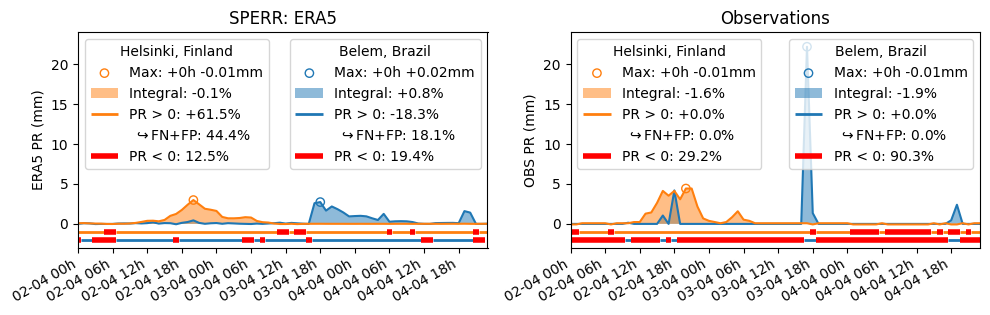

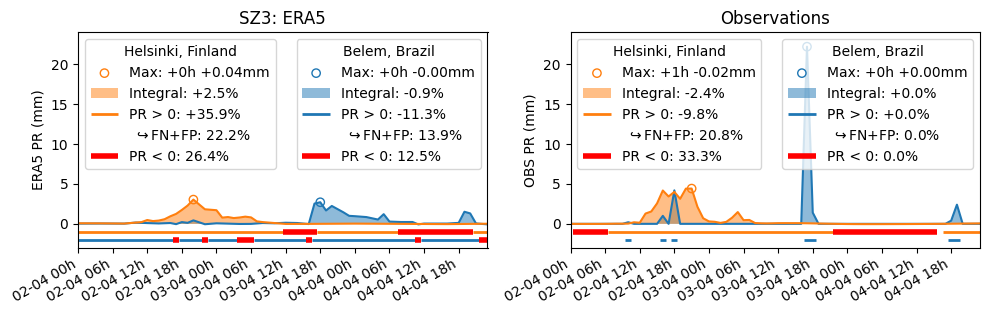

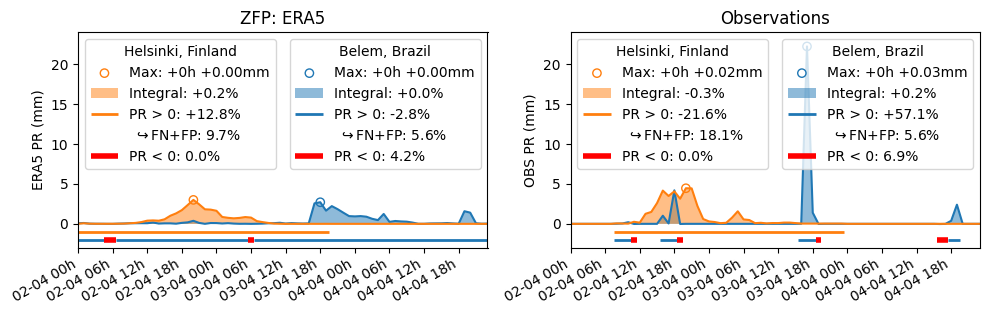

In [15]:
extract_and_plot(ERA5_PR_sperr, Belem_PR_sperr, Helsinki_PR_sperr, "SPERR")
extract_and_plot(ERA5_PR_sz3, Belem_PR_sz3, Helsinki_PR_sz3, "SZ3")
extract_and_plot(ERA5_PR_zfp, Belem_PR_zfp, Helsinki_PR_zfp, "ZFP")

In [16]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [17]:
sg_era5 = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(kind="eb", type="abs", eb=0.1),
        dict(kind="sign"),
        dict(kind="sign", offset=np.amax(ERA5_Belem_PR)),
        dict(kind="sign", offset=np.amax(ERA5_Helsinki_PR)),
    ],
)
ERA5_PR_sg = ERA5_PR.copy(data=sg_era5.decode(sg_era5.encode(ERA5_PR.values)))

In [18]:
sg_obs = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(kind="eb", type="abs", eb=0.1),
        dict(kind="sign"),
        # we only want to preserve *the* global maximum
        dict(kind="sign", offset="$x_max"),
    ],
)

Belem_PR_sg = Belem_PR.copy(deep=True)
Belem_PR_sg.values[:] = sg_obs.decode(sg_obs.encode(Belem_PR_sg.values))

Helsinki_PR_sg = Helsinki_PR.copy(deep=True)
Helsinki_PR_sg.values[:] = sg_obs.decode(sg_obs.encode(Helsinki_PR_sg.values))

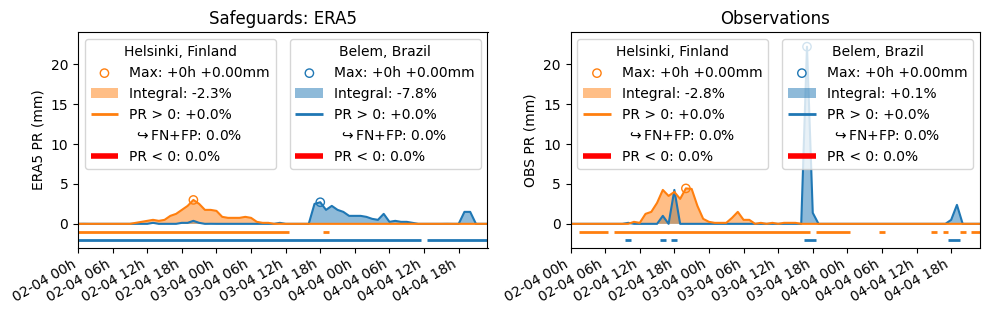

In [19]:
extract_and_plot(ERA5_PR_sg, Belem_PR_sg, Helsinki_PR_sg, "Safeguards")